In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "2"

In [2]:
import torch

if torch.cuda.is_available():
    print(f"Currently using GPU: {torch.cuda.get_device_name(torch.cuda.current_device())}")
else:
    print("No GPU detected. Ensure CUDA is properly installed.")


Currently using GPU: NVIDIA A100-SXM4-40GB


In [4]:
import pandas as pd
import numpy as np
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import optuna

In [9]:
# ====================================================
# Step 1: Load and Inspect the CSV File
# ====================================================

# Use the correct encoding if needed.
df = pd.read_csv("dataset.csv", encoding="latin1")
print("CSV Columns:", df.columns.tolist())

# Define column names based on your dataset
TEXT_COL = "Text"    # The column with the text
LABEL_COL = "Label"  # The column with labels ("hate", "non-hate")

# Verify required columns exist
if TEXT_COL not in df.columns:
    raise KeyError(f"Column '{TEXT_COL}' not found in CSV.")
if LABEL_COL not in df.columns:
    raise KeyError(f"Column '{LABEL_COL}' not found in CSV.")

CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']


In [10]:
# ====================================================
# Step 2: Data Cleaning and Label Mapping
# ====================================================
def clean_text(text):
    # Basic cleaning: lower case, strip extra whitespace.
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df[TEXT_COL] = df[TEXT_COL].apply(clean_text)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
df[LABEL_COL] = df[LABEL_COL].map(label_map)

In [12]:
# ====================================================
# Step 3: Remove Rows with Missing Labels and Train-Test Split
# ====================================================
# Drop rows where the label is NaN
df = df.dropna(subset=[LABEL_COL])
print("After dropping missing labels, dataset shape:", df.shape)

# Stratified split by label to preserve distribution
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[LABEL_COL])

After dropping missing labels, dataset shape: (1599, 7)


In [13]:

# ====================================================
# Step 4: Convert to Hugging Face Dataset
# ====================================================
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})


In [14]:
# ====================================================
# Step 5: Tokenization
# ====================================================
tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")

def tokenize_function(example):
    return tokenizer(example[TEXT_COL], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Keep only tokenized inputs and label
cols_to_keep = ["input_ids", "attention_mask", LABEL_COL]
tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in tokenized_datasets["train"].column_names if col not in cols_to_keep]
)
# Rename label column to "labels" as expected by Trainer
tokenized_datasets = tokenized_datasets.rename_column(LABEL_COL, "labels")
tokenized_datasets.set_format("torch")

tokenizer_config.json:   0%|          | 0.00/181 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/406 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/3.16M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Map:   0%|          | 0/1279 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

In [15]:
# ====================================================
# Step 6: Model Definition and Metrics
# ====================================================
def model_init():
    return AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

In [16]:
# ====================================================
# Step 7: Training Arguments & Early Stopping
# ====================================================
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',
    eval_steps=50,
    save_steps=50,
    logging_steps=10,
    learning_rate=2e-5,  # initial value; will be tuned
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # maximum epochs (early stopping may halt earlier)
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    weight_decay=0.01
)

/home/srmist20/.local/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


In [18]:
# ====================================================
# Step 8: Hyperparameter Tuning using Optuna
# ====================================================
def hp_space(trial):
    # Using suggest_float with log=True instead of deprecated suggest_loguniform.
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10)
    }

# Initialize Trainer for hyperparameter search
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting hyperparameter search...")
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=hp_space,
    n_trials=10, 
    compute_objective=lambda metrics: metrics["eval_accuracy"]
)
print("Best hyperparameters found:", best_run.hyperparameters)

# Update training arguments with best hyperparameters
training_args.learning_rate = best_run.hyperparameters.get("learning_rate", training_args.learning_rate)
training_args.per_device_train_batch_size = best_run.hyperparameters.get("per_device_train_batch_size", training_args.per_device_train_batch_size)
training_args.num_train_epochs = best_run.hyperparameters.get("num_train_epochs", training_args.num_train_epochs)

Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-27 15:04:07,503] A new study created in memory with name: no-name-5ca7bcf3-e956-4c3e-b2d8-a6ca61333463
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Starting hyperparameter search...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[W 2025-03-27 15:04:15,391] Trial 0 failed with parameters: {'learning_rate': 6.873994736886103e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 8} because of the following error: ValueError('Target size (torch.Size([4])) must be the same as input size (torch.Size([4, 2]))').
Traceback (most recent call last):
  File "/home/srmist20/.local/lib/python3.11/site-packages/optuna/study/_optimize.py", line 197, in _run_trial
    value_or_values = func(trial)
                      ^^^^^^^^^^^
  File "/home/srmist20/.local/lib/python3.11/site-packages/transformers/integrations/integration_utils.py", line 254, in _objective
    trainer.train(resume_from_checkpoint=checkpoint, trial=trial)
 

ValueError: Target size (torch.Size([4])) must be the same as input size (torch.Size([4, 2]))

In [ ]:
import pandas as pd       #padhna
import numpy as np
import re
from sklearn.model_selection import train_test_split
from datasets import Dataset, DatasetDict
import torch
from transformers import (AutoTokenizer, AutoModelForSequenceClassification, 
                          TrainingArguments, Trainer, EarlyStoppingCallback)
from sklearn.metrics import accuracy_score, precision_recall_fscore_support
import optuna

# ====================================================
# Step 1: Load and Inspect the CSV File
# ====================================================
df = pd.read_csv("dataset.csv", encoding="latin1")
print("CSV Columns:", df.columns.tolist())

# Define column names based on your dataset
TEXT_COL = "Text"    # The column with the text
LABEL_COL = "Label"  # The column with labels ("hate", "non-hate")

# Verify required columns exist
if TEXT_COL not in df.columns:
    raise KeyError(f"Column '{TEXT_COL}' not found in CSV.")
if LABEL_COL not in df.columns:
    raise KeyError(f"Column '{LABEL_COL}' not found in CSV.")

# ====================================================
# Step 2: Data Cleaning and Label Mapping
# ====================================================
def clean_text(text):
    # Basic cleaning: lower case, remove extra whitespace.
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

df[TEXT_COL] = df[TEXT_COL].apply(clean_text)

# First, drop rows where LABEL_COL is missing or not one of our expected values.
df = df[df[LABEL_COL].isin(["hate", "non-hate"])]
print("After filtering invalid labels, dataset shape:", df.shape)

# Now map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
df[LABEL_COL] = df[LABEL_COL].map(label_map).astype("int64")

# ====================================================
# Step 3: Train-Test Split
# ====================================================
# Stratified split by label to preserve distribution
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df[LABEL_COL])

# ====================================================
# Step 4: Convert to Hugging Face Dataset
# ====================================================
train_dataset = Dataset.from_pandas(train_df)
test_dataset = Dataset.from_pandas(test_df)
dataset = DatasetDict({
    'train': train_dataset,
    'test': test_dataset
})

# ====================================================
# Step 5: Tokenization
# ====================================================
tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")

def tokenize_function(example):
    return tokenizer(example[TEXT_COL], truncation=True, padding="max_length", max_length=128)

tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Keep only tokenized inputs and the label column
cols_to_keep = ["input_ids", "attention_mask", LABEL_COL]
tokenized_datasets = tokenized_datasets.remove_columns(
    [col for col in tokenized_datasets["train"].column_names if col not in cols_to_keep]
)
# Rename label column to "labels" as expected by Trainer
tokenized_datasets = tokenized_datasets.rename_column(LABEL_COL, "labels")
tokenized_datasets.set_format("torch")

# ====================================================
# Step 6: Model Definition and Metrics
# ====================================================
def model_init():
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)
    # Ensure the model uses single-label classification (CrossEntropyLoss)
    model.config.problem_type = "single_label_classification"
    return model

def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=-1)
    acc = accuracy_score(labels, predictions)
    precision, recall, f1, _ = precision_recall_fscore_support(labels, predictions, average='weighted')
    return {"accuracy": acc, "precision": precision, "recall": recall, "f1": f1}

# ====================================================
# Step 7: Training Arguments & Early Stopping
# ====================================================
training_args = TrainingArguments(
    output_dir='./results',
    evaluation_strategy='steps',
    eval_steps=50,
    save_steps=50,
    logging_steps=10,
    learning_rate=2e-5,  # initial value; will be tuned
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    num_train_epochs=10,  # maximum epochs (early stopping may halt earlier)
    load_best_model_at_end=True,
    metric_for_best_model="accuracy",
    greater_is_better=True,
    weight_decay=0.01
)

# ====================================================
# Step 8: Hyperparameter Tuning using Optuna
# ====================================================
def hp_space(trial):
    # Use suggest_float with log=True instead of deprecated suggest_loguniform.
    return {
        "learning_rate": trial.suggest_float("learning_rate", 1e-6, 1e-4, log=True),
        "per_device_train_batch_size": trial.suggest_categorical("per_device_train_batch_size", [4, 8, 16]),
        "num_train_epochs": trial.suggest_int("num_train_epochs", 3, 10)
    }

# Initialize Trainer for hyperparameter search
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting hyperparameter search...")
best_run = trainer.hyperparameter_search(
    direction="maximize",
    hp_space=hp_space,
    n_trials=10, 
    compute_objective=lambda metrics: metrics["eval_accuracy"]
)
print("Best hyperparameters found:", best_run.hyperparameters)

# Update training arguments with best hyperparameters
training_args.learning_rate = best_run.hyperparameters.get("learning_rate", training_args.learning_rate)
training_args.per_device_train_batch_size = best_run.hyperparameters.get("per_device_train_batch_size", training_args.per_device_train_batch_size)
training_args.num_train_epochs = best_run.hyperparameters.get("num_train_epochs", training_args.num_train_epochs)

# ====================================================
# Step 9: Final Training with Best Hyperparameters
# ====================================================
trainer = Trainer(
    model_init=model_init,
    args=training_args,
    train_dataset=tokenized_datasets['train'],
    eval_dataset=tokenized_datasets['test'],
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

print("Starting final training...")
trainer.train()

# ====================================================
# Step 10: Evaluation
# ====================================================
eval_results = trainer.evaluate()
print("Final evaluation results:", eval_results)


CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
After filtering invalid labels, dataset shape: (1599, 7)


Map:   0%|          | 0/1279 [00:00<?, ? examples/s]

Map:   0%|          | 0/320 [00:00<?, ? examples/s]

/home/srmist20/.local/lib/python3.11/site-packages/transformers/training_args.py:1611: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
[I 2025-03-27 15:09:52,101] A new study created in memory with name: no-name-08c3c57b-84f3-4bda-87d2-cda9e5d55fb6
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to

Starting hyperparameter search...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.228300,0.129566,0.993750,0.993827,0.993750,0.993750
100,0.009100,0.004831,1.000000,1.000000,1.000000,1.000000
150,0.002400,0.017395,0.996875,0.996894,0.996875,0.996875
200,0.001700,0.015567,0.996875,0.996894,0.996875,0.996875
250,0.024600,0.033644,0.993750,0.993827,0.993750,0.993750


[I 2025-03-27 15:12:00,888] Trial 0 finished with value: 0.99375 and parameters: {'learning_rate': 7.329700940840074e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 7}. Best is trial 0 with value: 0.99375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.089100,0.068704,0.990625,0.990798,0.990625,0.990624
100,0.219400,0.103625,0.978125,0.979042,0.978125,0.978115
150,0.092500,0.054089,0.990625,0.990644,0.990625,0.990625
200,0.040800,0.069904,0.990625,0.990798,0.990625,0.990624


[I 2025-03-27 15:13:38,367] Trial 1 finished with value: 0.990625 and parameters: {'learning_rate': 9.889637804398984e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.99375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.234200,0.135107,0.965625,0.965643,0.965625,0.965625
100,0.005700,0.030903,0.993750,0.993827,0.993750,0.993750
150,0.001100,0.023974,0.996875,0.996894,0.996875,0.996875
200,0.090500,0.031568,0.993750,0.993750,0.993750,0.993750
250,0.000800,0.200223,0.971875,0.973373,0.971875,0.971853
300,0.122100,0.109229,0.978125,0.979042,0.978125,0.978115


[I 2025-03-27 15:15:15,617] Trial 2 finished with value: 0.978125 and parameters: {'learning_rate': 1.0307721905163862e-05, 'per_device_train_batch_size': 4, 'num_train_epochs': 10}. Best is trial 0 with value: 0.99375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.213000,0.120960,0.993750,0.993827,0.993750,0.993750
100,0.011000,0.013128,0.996875,0.996894,0.996875,0.996875
150,0.003400,0.022677,0.993750,0.993827,0.993750,0.993750
200,0.002600,0.022499,0.993750,0.993827,0.993750,0.993750


[I 2025-03-27 15:17:16,254] Trial 3 finished with value: 0.99375 and parameters: {'learning_rate': 7.996666301231031e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 3}. Best is trial 0 with value: 0.99375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.595200,0.537841,0.771875,0.833989,0.771875,0.760751
100,0.356700,0.248208,0.968750,0.969410,0.968750,0.968739
150,0.102500,0.063871,0.984375,0.984394,0.984375,0.984375
200,0.013600,0.035567,0.990625,0.990798,0.990625,0.990624
250,0.018700,0.042798,0.990625,0.990798,0.990625,0.990624
300,0.002300,0.090711,0.984375,0.984848,0.984375,0.984371
350,0.001900,0.044646,0.993750,0.993827,0.993750,0.993750
400,0.001600,0.044286,0.993750,0.993827,0.993750,0.993750
450,0.001300,0.070084,0.987500,0.987805,0.987500,0.987498
500,0.000900,0.050946,0.993750,0.993827,0.993750,0.993750


[I 2025-03-27 15:19:58,145] Trial 4 finished with value: 0.99375 and parameters: {'learning_rate': 3.860218806701042e-06, 'per_device_train_batch_size': 4, 'num_train_epochs': 5}. Best is trial 0 with value: 0.99375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.615300,0.591761,0.693750,0.810078,0.693750,0.662054


[I 2025-03-27 15:20:18,660] Trial 5 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.235800,0.136938,0.996875,0.996894,0.996875,0.996875
100,0.010800,0.012559,0.996875,0.996894,0.996875,0.996875
150,0.004200,0.020313,0.993750,0.993750,0.993750,0.993750
200,0.001900,0.024114,0.993750,0.993827,0.993750,0.993750


[I 2025-03-27 15:21:57,198] Trial 6 finished with value: 0.99375 and parameters: {'learning_rate': 7.317080020106891e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 5}. Best is trial 0 with value: 0.99375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.458000,0.358703,0.934375,0.934392,0.934375,0.934374


[I 2025-03-27 15:22:13,153] Trial 7 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.338300,0.243250,0.975000,0.976190,0.975000,0.974984


[I 2025-03-27 15:22:35,961] Trial 8 pruned. 
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.045600,0.046238,0.993750,0.993750,0.993750,0.993750
100,0.001000,0.016886,0.996875,0.996894,0.996875,0.996875
150,0.000600,0.000360,1.000000,1.000000,1.000000,1.000000
200,0.000300,0.000092,1.000000,1.000000,1.000000,1.000000
250,0.000400,0.000254,1.000000,1.000000,1.000000,1.000000
300,0.033200,0.034692,0.990625,0.990798,0.990625,0.990624


[I 2025-03-27 15:24:58,702] Trial 9 finished with value: 0.990625 and parameters: {'learning_rate': 3.0057305559181324e-05, 'per_device_train_batch_size': 16, 'num_train_epochs': 7}. Best is trial 0 with value: 0.99375.
Detected kernel version 5.4.0, which is below the recommended minimum of 5.5.0; this can cause the process to hang. It is recommended to upgrade the kernel to the minimum version or higher.


Best hyperparameters found: {'learning_rate': 7.329700940840074e-06, 'per_device_train_batch_size': 16, 'num_train_epochs': 7}


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Starting final training...


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at google/muril-large-cased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Step,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
50,0.228300,0.129566,0.993750,0.993827,0.993750,0.993750
100,0.009100,0.004831,1.000000,1.000000,1.000000,1.000000
150,0.002400,0.017395,0.996875,0.996894,0.996875,0.996875
200,0.001700,0.015567,0.996875,0.996894,0.996875,0.996875
250,0.024600,0.033644,0.993750,0.993827,0.993750,0.993750


Final evaluation results: {'eval_loss': 0.004830740392208099, 'eval_accuracy': 1.0, 'eval_precision': 1.0, 'eval_recall': 1.0, 'eval_f1': 1.0, 'eval_runtime': 1.7718, 'eval_samples_per_second': 180.604, 'eval_steps_per_second': 22.576, 'epoch': 3.125}


In [27]:
trainer.save_model("./results")
tokenizer.save_pretrained("./results")


('./results/tokenizer_config.json',
 './results/special_tokens_map.json',
 './results/vocab.txt',
 './results/added_tokens.json',
 './results/tokenizer.json')

In [28]:
import os
from transformers import AutoTokenizer, AutoModelForSequenceClassification

saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer from saved directory.")
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved tokenizer not found. Loading tokenizer from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()


Loading tokenizer from saved directory.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(197285, 1024, padding_idx=0)
      (position_embeddings): Embedding(512, 1024)
      (token_type_embeddings): Embedding(2, 1024)
      (LayerNorm): LayerNorm((1024,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-23): 24 x BertLayer(
          (attention): BertAttention(
            (self): BertSdpaSelfAttention(
              (query): Linear(in_features=1024, out_features=1024, bias=True)
              (key): Linear(in_features=1024, out_features=1024, bias=True)
              (value): Linear(in_features=1024, out_features=1024, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=1024, out_features=1024, bias=True)
              (LayerNorm): LayerNorm((

In [29]:
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader

# Check if the model has been saved properly in "./results"
if not os.path.exists("./results/config.json"):
    raise ValueError("The './results' directory does not contain a valid config.json. "
                     "Make sure to save your model using trainer.save_model('./results') after training.")

# Load the tokenizer and fine-tuned model
tokenizer = AutoTokenizer.from_pretrained("./results")
model = AutoModelForSequenceClassification.from_pretrained("./results", num_labels=2)
model.config.problem_type = "single_label_classification"
model.eval()  # set model to evaluation mode

# -------------------------------
# 1. Evaluate on Held-Out Test Dataset
# -------------------------------

# Assuming tokenized_datasets['test'] is already available from your preprocessing pipeline
# Otherwise, load your test dataset from disk if you've saved it.
test_dataset = tokenized_datasets['test']  # replace with your actual test dataset

# Create DataLoader for evaluation
test_loader = DataLoader(test_dataset, batch_size=8)

all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch["labels"].numpy()
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_preds.extend(preds)
        all_labels.extend(labels)

print("Classification Report on Test Dataset:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

# -------------------------------
# 2. Manual Test Cases (Edge Cases) for Inference
# -------------------------------
test_texts = [
    # Clearly hateful statement in Hinglish
    "Ye politicians sirf vote ke liye kaam karte hain, desh ka kuch nahi sochte.",  
    # Clearly non-hateful positive review
    "Kal ki movie bohot achi thi, acting aur story dono lajawab!",
    # Some aggressive language that might be borderline
    "Tumhare jaise log hi society ko toxic banate ho.",
    # Neutral daily-life comment
    "Aaj ka weather kaisa hai? Bahar jane ka mood nahi hai.",
    # An English statement (non-hate)
    "I totally agree with you, great point!",
    # A hateful religious statement in Hinglish
    "Ye Muslims desh ke liye khatra hain, inko bahar nikal do.",
    # A statement advocating equality (non-hate)
    "Mujhe lagta hai ki sabko equal rights milne chahiye.",
    # Mixed language with slang, potential edge case
    "Yeh sab bakwaas baatein, kuch kaam ki baat karo!"
]

# (Optional) Expected labels for manual test cases: 1 for hate, 0 for non-hate.
expected_labels = [1, 0, 1, 0, 0, 1, 0, 1]  # adjust as per your expectations

print("\nManual Test Cases Predictions:")
for i, text in enumerate(test_texts):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1).item()
    pred_label = "hate" if pred == 1 else "non-hate"
    print(f"Test Case {i+1}:")
    print(f"  Input Text: {text}")
    if expected_labels:
        true_label = "hate" if expected_labels[i] == 1 else "non-hate"
        print(f"  Expected Label: {true_label}")
    print(f"  Predicted Label: {pred_label}\n")


Classification Report on Test Dataset:
              precision    recall  f1-score   support

    non-hate       1.00      1.00      1.00       160
        hate       1.00      1.00      1.00       160

    accuracy                           1.00       320
   macro avg       1.00      1.00      1.00       320
weighted avg       1.00      1.00      1.00       320

Confusion Matrix:
[[160   0]
 [  0 160]]

Manual Test Cases Predictions:
Test Case 1:
  Input Text: Ye politicians sirf vote ke liye kaam karte hain, desh ka kuch nahi sochte.
  Expected Label: hate
  Predicted Label: hate

Test Case 2:
  Input Text: Kal ki movie bohot achi thi, acting aur story dono lajawab!
  Expected Label: non-hate
  Predicted Label: non-hate

Test Case 3:
  Input Text: Tumhare jaise log hi society ko toxic banate ho.
  Expected Label: hate
  Predicted Label: hate

Test Case 4:
  Input Text: Aaj ka weather kaisa hai? Bahar jane ka mood nahi hai.
  Expected Label: non-hate
  Predicted Label: non-hate

Test 

In [1]:
import os
import torch
import numpy as np
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------
# Load Model and Tokenizer
# ------------------------------------------
# Update saved_model_dir if needed. This example falls back to pretrained if saved files are not available.
saved_model_dir = "./results"

if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory.")
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)

# Ensure model uses CrossEntropyLoss by setting the problem type
model.config.problem_type = "single_label_classification"
model.eval()

# ------------------------------------------
# Define Entirely New Test Cases (Not Seen During Training)
# ------------------------------------------
# Here are some new test cases along with their expected labels:
# For this example, 1 indicates 'hate' and 0 indicates 'non-hate'.
new_test_texts = [
    "Yeh naya policy bahut hi damaging hai, desh ko barbaad kar degi.",  # hate
    "Aaj ka din bahut shant aur sukhad raha, sab log khush hain.",           # non-hate
    "Tumhare jaisi soch samajh mein kami hai, bas aise hi sabko ganda bana dete ho.",  # hate
    "Main aaj market gaya aur wahan sab log ek dusre ki madad karte hue dekha.",         # non-hate
    "Political leaders are corrupt and must be removed from power immediately.",       # hate (English)
    "The new government policy has positively impacted the economy.",                  # non-hate (English)
    "This community should respect diversity and work together for progress.",         # non-hate
    "Aise log jo sirf apne fayde ke liye desh ka nuksan karte hain, unhe sakt saja milni chahiye."  # hate
]
expected_new_labels = [1, 0, 1, 0, 1, 0, 0, 1]

# ------------------------------------------
# Inference on New Test Cases
# ------------------------------------------
new_predictions = []
for i, text in enumerate(new_test_texts):
    inputs = tokenizer(text, return_tensors="pt", truncation=True, padding="max_length", max_length=128)
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    pred = torch.argmax(logits, dim=-1).item()
    new_predictions.append(pred)
    pred_label = "hate" if pred == 1 else "non-hate"
    print(f"New Test Case {i+1}:")
    print(f"  Input Text      : {text}")
    print(f"  Expected Label  : {'hate' if expected_new_labels[i]==1 else 'non-hate'}")
    print(f"  Predicted Label : {pred_label}\n")

# ------------------------------------------
# Evaluation Metrics for New Test Cases
# ------------------------------------------
print("Evaluation on New Test Cases:")
print(classification_report(expected_new_labels, new_predictions, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(expected_new_labels, new_predictions))


Loading tokenizer and model from saved directory.


2025-03-28 10:15:07.022659: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743137107.039541 2743320 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743137107.045266 2743320 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743137107.060264 2743320 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743137107.060279 2743320 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743137107.060281 2743320 computation_placer.cc:177] computation placer alr

New Test Case 1:
  Input Text      : Yeh naya policy bahut hi damaging hai, desh ko barbaad kar degi.
  Expected Label  : hate
  Predicted Label : hate

New Test Case 2:
  Input Text      : Aaj ka din bahut shant aur sukhad raha, sab log khush hain.
  Expected Label  : non-hate
  Predicted Label : non-hate

New Test Case 3:
  Input Text      : Tumhare jaisi soch samajh mein kami hai, bas aise hi sabko ganda bana dete ho.
  Expected Label  : hate
  Predicted Label : hate

New Test Case 4:
  Input Text      : Main aaj market gaya aur wahan sab log ek dusre ki madad karte hue dekha.
  Expected Label  : non-hate
  Predicted Label : non-hate

New Test Case 5:
  Input Text      : Political leaders are corrupt and must be removed from power immediately.
  Expected Label  : hate
  Predicted Label : non-hate

New Test Case 6:
  Input Text      : The new government policy has positively impacted the economy.
  Expected Label  : non-hate
  Predicted Label : non-hate

New Test Case 7:
  Input Text

In [3]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset

# ------------------------------------------
# Step 1: Load and Preprocess the Test CSV
# ------------------------------------------
# Read the CSV file. Adjust the encoding if necessary.
test_df = pd.read_csv("Data final.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

# We assume the text is in the "Text" column and labels are in "Label".
# Apply basic cleaning to the text.
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)

# Drop rows with missing or invalid labels
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------
# Step 2: Create a Custom Dataset for Test Data
# ------------------------------------------
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["Text"]
        inputs = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Squeeze to remove extra batch dimension and add the label
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item["labels"] = torch.tensor(int(self.df.iloc[idx]["Label"]))
        return item

# ------------------------------------------
# Step 3: Load Model and Tokenizer
# ------------------------------------------
# Try to load the saved model and tokenizer from "./results"
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory.")
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)

# Ensure the model uses CrossEntropyLoss by setting problem_type
model.config.problem_type = "single_label_classification"
model.eval()  # set to evaluation mode

# ------------------------------------------
# Step 4: Create DataLoader for Test Dataset
# ------------------------------------------
test_dataset = TestDataset(test_df, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=8)

# ------------------------------------------
# Step 5: Run Inference and Evaluate
# ------------------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Only pass the required inputs to the model
        inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch["labels"].numpy()
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_preds.extend(preds)
        all_labels.extend(labels)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (467, 7)
Loading tokenizer and model from saved directory.

Classification Report:
              precision    recall  f1-score   support

    non-hate       0.64      0.99      0.78       231
        hate       0.98      0.46      0.62       236

    accuracy                           0.72       467
   macro avg       0.81      0.72      0.70       467
weighted avg       0.81      0.72      0.70       467

Confusion Matrix:
[[229   2]
 [128 108]]


In [1]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix
from torch.utils.data import DataLoader, Dataset

# ------------------------------------------
# Step 1: Load and Preprocess the Test CSV
# ------------------------------------------
# Read the CSV file. Adjust the encoding if necessary.
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

# We assume the text is in the "Text" column and labels are in "Label".
# Apply basic cleaning to the text.
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map string labels to integers: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)

# Drop rows with missing or invalid labels
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------
# Step 2: Create a Custom Dataset for Test Data
# ------------------------------------------
class TestDataset(Dataset):
    def __init__(self, dataframe, tokenizer, max_length=128):
        self.df = dataframe
        self.tokenizer = tokenizer
        self.max_length = max_length
        
    def __len__(self):
        return len(self.df)
    
    def __getitem__(self, idx):
        text = self.df.iloc[idx]["Text"]
        inputs = self.tokenizer(
            text, 
            truncation=True, 
            padding="max_length", 
            max_length=self.max_length,
            return_tensors="pt"
        )
        # Squeeze to remove extra batch dimension and add the label
        item = {key: val.squeeze(0) for key, val in inputs.items()}
        item["labels"] = torch.tensor(int(self.df.iloc[idx]["Label"]))
        return item

# ------------------------------------------
# Step 3: Load Model and Tokenizer
# ------------------------------------------
# Try to load the saved model and tokenizer from "./results"
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory.")
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)

# Ensure the model uses CrossEntropyLoss by setting problem_type
model.config.problem_type = "single_label_classification"
model.eval()  # set to evaluation mode

# ------------------------------------------
# Step 4: Create DataLoader for Test Dataset
# ------------------------------------------
test_dataset = TestDataset(test_df, tokenizer, max_length=128)
test_loader = DataLoader(test_dataset, batch_size=8)

# ------------------------------------------
# Step 5: Run Inference and Evaluate
# ------------------------------------------
all_preds = []
all_labels = []

with torch.no_grad():
    for batch in test_loader:
        # Only pass the required inputs to the model
        inputs = {k: v for k, v in batch.items() if k in ['input_ids', 'attention_mask']}
        labels = batch["labels"].numpy()
        outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        preds = np.argmax(logits, axis=-1)
        all_preds.extend(preds)
        all_labels.extend(labels)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)
Loading tokenizer and model from saved directory.


2025-03-28 11:56:17.809373: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743143177.825921 2866134 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743143177.831745 2866134 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743143177.846108 2866134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743143177.846124 2866134 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743143177.846126 2866134 computation_placer.cc:177] computation placer alr


Classification Report:
              precision    recall  f1-score   support

    non-hate       0.89      1.00      0.94        50
        hate       1.00      0.88      0.94        50

    accuracy                           0.94       100
   macro avg       0.95      0.94      0.94       100
weighted avg       0.95      0.94      0.94       100

Confusion Matrix:
[[50  0]
 [ 6 44]]


In [3]:
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
import numpy as np

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load the fine-tuned MuRIL model and tokenizer from the "results" folder
model_path = "results"  # ensure this path contains your saved model files
tokenizer = AutoTokenizer.from_pretrained(model_path)
model = AutoModelForSequenceClassification.from_pretrained(model_path)
model.to(device)
model.eval()

print("Model and Tokenizer loaded successfully!")

2025-04-01 11:12:19.804178: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743486139.853427  886215 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743486139.865481  886215 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743486139.935131  886215 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743486139.935166  886215 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743486139.935168  886215 computation_placer.cc:177] computation placer alr

Model and Tokenizer loaded successfully!


In [4]:
prompt_templates = {
    "zero_shot": (
        "Classify the following Hinglish text as either Hate Speech or Non-Hate Speech.\n\n"
        "Text: \"{text}\"\n\nAnswer:"
    ),
    "few_shot": (
        "Example 1:\nText: \"Tum log bohot badtameez ho\" => Hate Speech.\n\n"
        "Example 2:\nText: \"I love spending time with my family\" => Non-Hate Speech.\n\n"
        "Now, classify the following text:\nText: \"{text}\"\n\nAnswer:"
    ),
    "chain_of_thought": (
        "Analyze the following Hinglish text step by step to decide if it is Hate Speech or Non-Hate Speech.\n"
        "Explain your reasoning briefly and then provide the final classification.\n\n"
        "Text: \"{text}\"\n\nReasoning: <reasoning here> \n\nAnswer:"
    )
}

def classify_with_prompt(prompt_key, text):
    """
    Classify a given text using a specified prompting strategy.
    
    Args:
      prompt_key (str): One of "zero_shot", "few_shot", or "chain_of_thought".
      text (str): The input Hinglish text.
    
    Returns:
      predicted_label (str): "Hate Speech" or "Non-Hate Speech".
      prompt_text (str): The full prompt text that was used.
    """
    # Retrieve the selected prompt template
    template = prompt_templates.get(prompt_key)
    if template is None:
        raise ValueError("Invalid prompt key. Choose from: zero_shot, few_shot, chain_of_thought.")
    
    # Build the complete prompt
    prompt_text = template.format(text=text)
    
    # Tokenize the prompt; adjust max_length if needed
    inputs = tokenizer(prompt_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits  # shape: [batch_size, num_labels]
    predicted_class = torch.argmax(logits, dim=-1).item()
    
    # Map numeric predictions to labels (adjust if your mapping is different)
    label_map = {0: "Non-Hate Speech", 1: "Hate Speech"}
    predicted_label = label_map.get(predicted_class, "Unknown")
    
    return predicted_label, prompt_text

# Example usage:
sample_text = "Tu pagal hai kya? Tera dimag kharab ho gaya hai!"
for strategy in prompt_templates.keys():
    prediction, used_prompt = classify_with_prompt(strategy, sample_text)
    print(f"Strategy: {strategy}")
    print("Prompt:\n", used_prompt)
    print("Prediction:", prediction)
    print("-" * 50)


# Example test texts; you can replace this with your test set.
test_texts = [
    "Yaar, yeh traffic BC kab khatam hoga? Roz late ho jati hai.",
    "Just had the best momos at the new stall in town!",
    "BC, yeh politicians sab chor hain. Tax ka paisa ghat raha hai.",
    "Kal concert ka plan hai? Tickets are selling fast!",
    "Saale, tu jhaat bhar ka nahi, gyaan chodne aata hai."
]

results = {strategy: [] for strategy in prompt_templates.keys()}

for text in test_texts:
    for strategy in prompt_templates.keys():
        pred, _ = classify_with_prompt(strategy, text)
        results[strategy].append(pred)

# Print batch results
for strategy, preds in results.items():
    print(f"Strategy: {strategy}")
    for t, p in zip(test_texts, preds):
        print(f"Text: {t}\nPrediction: {p}\n{'-'*40}")
    print("\n")


Strategy: zero_shot
Prompt:
 Classify the following Hinglish text as either Hate Speech or Non-Hate Speech.

Text: "Tu pagal hai kya? Tera dimag kharab ho gaya hai!"

Answer:
Prediction: Hate Speech
--------------------------------------------------
Strategy: few_shot
Prompt:
 Example 1:
Text: "Tum log bohot badtameez ho" => Hate Speech.

Example 2:
Text: "I love spending time with my family" => Non-Hate Speech.

Now, classify the following text:
Text: "Tu pagal hai kya? Tera dimag kharab ho gaya hai!"

Answer:
Prediction: Hate Speech
--------------------------------------------------
Strategy: chain_of_thought
Prompt:
 Analyze the following Hinglish text step by step to decide if it is Hate Speech or Non-Hate Speech.
Explain your reasoning briefly and then provide the final classification.

Text: "Tu pagal hai kya? Tera dimag kharab ho gaya hai!"

Reasoning: <reasoning here> 

Answer:
Prediction: Hate Speech
--------------------------------------------------
Strategy: zero_shot
Text: 

In [7]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------
# Step 1: Load and Prepare the Fine-Tuned Model & Tokenizer
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory.")
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)
model.config.problem_type = "single_label_classification"
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode!")

# ------------------------------------------------------
# Step 2: Define Prompt Templates and Classification Function
# ------------------------------------------------------
prompt_templates = {
    "zero_shot": (
        "Classify the following Hinglish text as either Hate Speech or Non-Hate Speech.\n\n"
        "Text: \"{text}\"\n\nAnswer:"
    ),
    "few_shot": (
        "Example 1:\nText: \"Tum log bohot badtameez ho\" => Hate Speech.\n\n"
        "Example 2:\nText: \"I love spending time with my family\" => Non-Hate Speech.\n\n"
        "Now, classify the following text:\nText: \"{text}\"\n\nAnswer:"
    ),
    "chain_of_thought": (
        "Analyze the following Hinglish text step by step to decide if it is Hate Speech or Non-Hate Speech.\n"
        "Explain your reasoning briefly and then provide the final classification.\n\n"
        "Text: \"{text}\"\n\nReasoning: <explain here>\n\nAnswer:"
    )
}

def classify_with_prompt(prompt_key, text):
    # Retrieve prompt template
    template = prompt_templates.get(prompt_key)
    if not template:
        raise ValueError("Invalid prompt key. Choose from: zero_shot, few_shot, chain_of_thought.")
    # Build the complete prompt
    prompt_text = template.format(text=text)
    # Tokenize the prompt
    inputs = tokenizer(prompt_text, return_tensors="pt", padding=True, truncation=True, max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    # Get model predictions
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits  # shape: [batch_size, num_labels]
    predicted_class = torch.argmax(logits, dim=-1).item()
    # Map numeric prediction to human-readable label (assume: 0: Non-Hate Speech, 1: Hate Speech)
    label_map = {0: "Non-Hate Speech", 1: "Hate Speech"}
    predicted_label = label_map.get(predicted_class, "Unknown")
    return predicted_label, prompt_text

# ------------------------------------------------------
# Step 3: Load and Preprocess the Test Dataset
# ------------------------------------------------------
# Load the test CSV file (adjust path/encoding as necessary)
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

# Clean text function
def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)
# Map labels ("hate" -> 1, "non-hate" -> 0)
label_map_csv = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map_csv)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------------------
# Step 4: Evaluate Model Using Prompting on the Test Dataset
# ------------------------------------------------------
all_preds = []
all_labels = []

# Choose a prompt strategy: "zero_shot", "few_shot", or "chain_of_thought"
selected_prompt = "chain_of_thought"

for idx, row in test_df.iterrows():
    text = row["Text"]
    true_label = row["Label"]
    pred_label, prompt_used = classify_with_prompt(selected_prompt, text)
    # Convert predicted label to numeric (Non-Hate Speech -> 0, Hate Speech -> 1)
    pred_numeric = 1 if pred_label == "Hate Speech" else 0
    all_preds.append(pred_numeric)
    all_labels.append(true_label)

# Compute and display evaluation metrics
print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Loading tokenizer and model from saved directory.
Model loaded and set to evaluation mode!
Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)

Classification Report:
              precision    recall  f1-score   support

    non-hate       0.78      1.00      0.88        50
        hate       1.00      0.72      0.84        50

    accuracy                           0.86       100
   macro avg       0.89      0.86      0.86       100
weighted avg       0.89      0.86      0.86       100

Confusion Matrix:
[[50  0]
 [14 36]]


In [8]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------------------------------
# Step 1: Load and Prepare the Fine-Tuned Model & Tokenizer
# ------------------------------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory.")
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("google/muril-large-cased")
    model = AutoModelForSequenceClassification.from_pretrained("google/muril-large-cased", num_labels=2)
model.config.problem_type = "single_label_classification"
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode!")

# ------------------------------------------------------
# Step 2: Define Refined Prompt Templates
# ------------------------------------------------------
# High-quality prompts aimed at achieving higher accuracy
prompt_templates = {
    "zero_shot": (
        "You are an expert in analyzing online content in Hinglish (a mix of Hindi and English). "
        "Please classify the following text as either 'Hate Speech' or 'Non-Hate Speech'.\n\n"
        "Text: \"{text}\"\n\n"
        "Answer:"
    ),
    "few_shot": (
        "Below are examples of classifying Hinglish texts:\n\n"
        "Example 1:\n"
        "Text: \"Tum log bohot badtameez ho, sabka dimag kharab kar dete ho\"\n"
        "Classification: Hate Speech\n\n"
        "Example 2:\n"
        "Text: \"I love spending time with my family and friends\"\n"
        "Classification: Non-Hate Speech\n\n"
        "Now, classify the following text accordingly:\n"
        "Text: \"{text}\"\n\n"
        "Answer:"
    ),
    "chain_of_thought": (
        "Analyze the following Hinglish text step by step and provide your reasoning before giving the final classification.\n"
        "Consider both Hindi and English parts, cultural nuances, and slang. If the text includes insults or promotes harm, classify it as 'Hate Speech'; otherwise, classify it as 'Non-Hate Speech'.\n\n"
        "Text: \"{text}\"\n\n"
        "Reasoning: [Briefly explain your thought process here]\n\n"
        "Final Classification (Answer only 'Hate Speech' or 'Non-Hate Speech'):"
    )
}

def classify_with_prompt(prompt_key, text):
    """
    Classify a given text using a specified prompting strategy.
    Returns the predicted label and the prompt used.
    """
    template = prompt_templates.get(prompt_key)
    if not template:
        raise ValueError("Invalid prompt key. Choose from: zero_shot, few_shot, chain_of_thought.")
    prompt_text = template.format(text=text)
    inputs = tokenizer(prompt_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    
    with torch.no_grad():
        outputs = model(**inputs)
    logits = outputs.logits
    predicted_class = torch.argmax(logits, dim=-1).item()
    label_map = {0: "Non-Hate Speech", 1: "Hate Speech"}
    predicted_label = label_map.get(predicted_class, "Unknown")
    return predicted_label, prompt_text

# ------------------------------------------------------
# Step 3: Load and Preprocess the Test Dataset
# ------------------------------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)
label_map_csv = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map_csv)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------------------------------
# Step 4: Evaluate Model Using Ensemble of Prompting Strategies on the Test Dataset
# ------------------------------------------------------
all_preds = []
all_labels = []

# Use all prompting strategies
prompt_keys = ["zero_shot", "few_shot", "chain_of_thought"]

for idx, row in test_df.iterrows():
    text = row["Text"]
    true_label = row["Label"]
    
    # Collect predictions from each prompt strategy
    strategy_preds = []
    for key in prompt_keys:
        pred_label, _ = classify_with_prompt(key, text)
        pred_numeric = 1 if pred_label == "Hate Speech" else 0
        strategy_preds.append(pred_numeric)
    
    # Ensemble via majority vote
    final_prediction = int(np.round(np.mean(strategy_preds)))  
    all_preds.append(final_prediction)
    all_labels.append(true_label)

print("\nClassification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))

Loading tokenizer and model from saved directory.
Model loaded and set to evaluation mode!
Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)

Classification Report:
              precision    recall  f1-score   support

    non-hate       0.77      0.96      0.86        50
        hate       0.95      0.72      0.82        50

    accuracy                           0.84       100
   macro avg       0.86      0.84      0.84       100
weighted avg       0.86      0.84      0.84       100

Confusion Matrix:
[[48  2]
 [14 36]]


In [9]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Load your saved model and tokenizer
# ------------------------------
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------
# Load and preprocess the test CSV
# ------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map labels: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------
# Define prompting functions
# ------------------------------
def zero_shot_prompt(text):
    # Zero-shot: simply prepend an instruction.
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text, examples):
    # Few-shot: include a few examples in the prompt.
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        prompt += f"Text: {ex_text}\nLabel: {ex_label}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    # Chain-of-thought: instruct the model to think step by step.
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# Define a few-shot example list (tweak these examples as needed)
few_shot_examples = [
    ("i hate when people are rude", "hate"),
    ("i love when people are kind", "non-hate")
]

# ------------------------------
# Function to run inference with a given prompt function
# ------------------------------
def run_prompt_inference(df, prompt_func, **kwargs):
    all_preds = []
    all_labels = []
    for idx, row in df.iterrows():
        original_text = row["Text"]
        true_label = int(row["Label"])
        # Create the prompt using the provided function (pass additional arguments if needed)
        if kwargs:
            prompt_text = prompt_func(original_text, **kwargs)
        else:
            prompt_text = prompt_func(original_text)
        # Tokenize the prompt
        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.detach().cpu().numpy()
        pred = np.argmax(logits, axis=-1)[0]
        all_preds.append(pred)
        all_labels.append(true_label)
    return all_preds, all_labels

# ------------------------------
# Run inference for each prompting technique
# ------------------------------
zero_preds, zero_labels = run_prompt_inference(test_df, zero_shot_prompt)
few_preds, few_labels = run_prompt_inference(test_df, few_shot_prompt, examples=few_shot_examples)
cot_preds, cot_labels = run_prompt_inference(test_df, chain_of_thought_prompt)

# ------------------------------
# Evaluate and visualize results
# ------------------------------
print("Zero-Shot Prompting Results:")
print(classification_report(zero_labels, zero_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(zero_labels, zero_preds))

print("\nFew-Shot Prompting Results:")
print(classification_report(few_labels, few_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(few_labels, few_preds))

print("\nChain-of-Thought Prompting Results:")
print(classification_report(cot_labels, cot_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(cot_labels, cot_preds))


Loading tokenizer and model from saved directory: ./results
Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)
Zero-Shot Prompting Results:
              precision    recall  f1-score   support

    non-hate       0.89      0.98      0.93        50
        hate       0.98      0.88      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100

Confusion Matrix:
[[49  1]
 [ 6 44]]

Few-Shot Prompting Results:
              precision    recall  f1-score   support

    non-hate       0.81      1.00      0.89        50
        hate       1.00      0.76      0.86        50

    accuracy                           0.88       100
   macro avg       0.90      0.88      0.88       100
weighted avg       0.90      0.88      0.88       100

Confusion Matrix:
[[50  0]
 [12 38]]

Chain-of-Th

In [10]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Step 1: Load and Prepare the Fine-Tuned Model & Tokenizer
# ------------------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.to(device)
model.eval()
print("Model loaded and set to evaluation mode!")

# ------------------------------
# Step 2: Define Refined Prompt Templates
# ------------------------------
# High-quality prompt templates for each strategy
def zero_shot_prompt(text):
    return f"You are an expert in analyzing online content in Hinglish (a mix of Hindi and English). " \
           f"Please classify the following text as either 'Hate Speech' or 'Non-Hate Speech'.\n\n" \
           f"Text: \"{text}\"\n\nAnswer:"

def few_shot_prompt(text, examples):
    prompt = "Below are examples of classifying Hinglish texts:\n\n"
    for ex_text, ex_label in examples:
        prompt += f"Text: \"{ex_text}\"\nClassification: {ex_label}\n\n"
    prompt += f"Now, classify the following text accordingly:\nText: \"{text}\"\n\nAnswer:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Analyze the following Hinglish text step by step and provide your reasoning before giving the final classification.\n" \
           f"Consider both Hindi and English parts, cultural nuances, and slang. If the text includes insults or promotes harm, " \
           f"classify it as 'Hate Speech'; otherwise, classify it as 'Non-Hate Speech'.\n\n" \
           f"Text: \"{text}\"\n\nReasoning: [Explain your thought process here]\n\nFinal Classification (Answer only 'Hate Speech' or 'Non-Hate Speech'):"

# Define few-shot examples (adjust as needed)
few_shot_examples = [
    ("Tum log bohot badtameez ho", "Hate Speech"),
    ("I love spending time with my family", "Non-Hate Speech")
]

# Dictionary of prompt functions for easier iteration
prompt_functions = {
    "zero_shot": zero_shot_prompt,
    "few_shot": lambda text: few_shot_prompt(text, few_shot_examples),
    "chain_of_thought": chain_of_thought_prompt
}

# ------------------------------
# Step 3: Load and Preprocess the Test Dataset
# ------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)
label_map_csv = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map_csv)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------
# Step 4: Ensemble Inference using Multiple Prompting Methods
# ------------------------------
def ensemble_classify(text, prompt_funcs):
    """
    For a given text, run each prompting method and return the final ensemble prediction
    using majority voting. If there is a tie, default to zero_shot prediction.
    """
    preds = []
    for key, prompt_func in prompt_funcs.items():
        prompt_text = prompt_func(text)
        inputs = tokenizer(prompt_text, return_tensors="pt", padding=True, truncation=True, max_length=256)
        inputs = {k: v.to(device) for k, v in inputs.items()}
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits
        pred_class = torch.argmax(logits, dim=-1).item()
        preds.append(pred_class)
    # Majority vote
    preds_array = np.array(preds)
    # If tie, use zero_shot prediction as default (index 0 in list)
    if np.sum(preds_array == 0) == np.sum(preds_array == 1):
        final_pred = preds[0]  # default to first method (zero_shot if ordering preserved)
    else:
        final_pred = int(np.round(np.mean(preds_array)))
    return final_pred, preds  # returning final prediction and individual predictions for analysis

all_preds = []
all_labels = []

for idx, row in test_df.iterrows():
    text = row["Text"]
    true_label = int(row["Label"])
    final_pred, individual_preds = ensemble_classify(text, prompt_functions)
    all_preds.append(final_pred)
    all_labels.append(true_label)

# ------------------------------
# Step 5: Evaluate and Visualize the Results
# ------------------------------
print("\nEnsembled Prompting Classification Report:")
print(classification_report(all_labels, all_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(all_labels, all_preds))


Loading tokenizer and model from saved directory: ./results
Model loaded and set to evaluation mode!
Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)

Ensembled Prompting Classification Report:
              precision    recall  f1-score   support

    non-hate       0.78      0.98      0.87        50
        hate       0.97      0.72      0.83        50

    accuracy                           0.85       100
   macro avg       0.88      0.85      0.85       100
weighted avg       0.88      0.85      0.85       100

Confusion Matrix:
[[49  1]
 [14 36]]


In [11]:
import os
import torch
import pandas as pd
import numpy as np
import re
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix

# ------------------------------
# Load your saved model and tokenizer
# ------------------------------
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from the original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()  # Set model to evaluation mode

# ------------------------------
# Load and preprocess the test CSV
# ------------------------------
test_df = pd.read_csv("TEST.csv", encoding="latin1")
print("Test CSV Columns:", test_df.columns.tolist())

def clean_text(text):
    text = str(text).lower()
    text = re.sub(r'\s+', ' ', text)
    return text.strip()

test_df["Text"] = test_df["Text"].apply(clean_text)

# Map labels: "hate" -> 1, "non-hate" -> 0.
label_map = {"hate": 1, "non-hate": 0}
test_df["Label"] = test_df["Label"].map(label_map)
test_df = test_df.dropna(subset=["Label"])
print("Test data shape after cleaning:", test_df.shape)

# ------------------------------
# Define prompting functions
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text, examples):
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        prompt += f"Text: {ex_text}\nLabel: {ex_label}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# Define few-shot examples
few_shot_examples = [
    ("i hate when people are rude", "hate"),
    ("i love when people are kind", "non-hate")
]

# ------------------------------
# Run inference for all prompting methods and combine results
# ------------------------------
def run_combined_inference(df):
    all_preds = []
    all_labels = []
    for idx, row in df.iterrows():
        original_text = row["Text"]
        true_label = int(row["Label"])

        # Generate prompts
        zero_prompt = zero_shot_prompt(original_text)
        few_prompt = few_shot_prompt(original_text, few_shot_examples)
        cot_prompt = chain_of_thought_prompt(original_text)

        # Tokenize and predict for each prompt
        prompts = [zero_prompt, few_prompt, cot_prompt]
        predictions = []
        
        for prompt in prompts:
            inputs = tokenizer(prompt, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
            inputs = {k: v.to(model.device) for k, v in inputs.items()}
            
            with torch.no_grad():
                outputs = model(**inputs)
            logits = outputs.logits.detach().cpu().numpy()
            pred = np.argmax(logits, axis=-1)[0]
            predictions.append(pred)
        
        # Majority voting (or averaging for softer decisions)
        final_pred = round(np.mean(predictions))
        all_preds.append(final_pred)
        all_labels.append(true_label)
    
    return all_preds, all_labels

# Run combined inference
final_preds, final_labels = run_combined_inference(test_df)

# ------------------------------
# Evaluate and visualize results
# ------------------------------
print("Final Combined Model Results:")
print(classification_report(final_labels, final_preds, target_names=["non-hate", "hate"]))
print("Confusion Matrix:")
print(confusion_matrix(final_labels, final_preds))

Loading tokenizer and model from saved directory: ./results
Test CSV Columns: ['ID', 'Text', 'Label', 'Parent_Text', 'Hashtags', 'Language_Script', 'Sentiment']
Test data shape after cleaning: (100, 7)
Final Combined Model Results:
              precision    recall  f1-score   support

    non-hate       0.83      0.98      0.90        50
        hate       0.98      0.80      0.88        50

    accuracy                           0.89       100
   macro avg       0.90      0.89      0.89       100
weighted avg       0.90      0.89      0.89       100

Confusion Matrix:
[[49  1]
 [10 40]]


In [ ]:
import os
import torch
import pandas as pd
import numpy as np
import re
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sentence_transformers import SentenceTransformer

# ------------------------------
# Load and Preprocess Dataset
# ------------------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, encoding="latin1")
    
    # Data Cleaning
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df["Text"] = df["Text"].apply(clean_text)
    
    # Convert labels: "hate" -> 1, "non-hate" -> 0
    label_map = {"hate": 1, "non-hate": 0}
    df["Label"] = df["Label"].map(label_map)
    df = df.dropna(subset=["Label"])
    
    return df

train_file_path = "dataset.csv"
test_file_path = "TEST.csv"

df_train = load_and_preprocess(train_file_path)
df_test = load_and_preprocess(test_file_path)

# ------------------------------
# Load Model & Tokenizer
# ------------------------------
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

model.config.problem_type = "single_label_classification"
model.eval()

# ------------------------------
# FAISS-based RAG Setup
# ------------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df_train["Text"].tolist()
labels = df_train["Label"].tolist()

# Convert texts to embeddings
embeddings = embedding_model.encode(texts, convert_to_numpy=True)

# Create FAISS index
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

def retrieve_similar_examples(query_text, top_k=3):
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    distances, indices = faiss_index.search(query_embedding, top_k)
    examples = [(texts[i], labels[i]) for i in indices[0]]
    return examples

# ------------------------------
# Define Prompting Techniques with RAG
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# ------------------------------
# Run Inference Function
# ------------------------------
def run_inference(df, prompt_func):
    all_preds = []
    all_labels = []
    all_probs = []  # For ROC curve
    for _, row in df.iterrows():
        text, true_label = row["Text"], int(row["Label"])
        prompt_text = prompt_func(text)
        
        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(model.device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        
        pred = np.argmax(logits, axis=-1)[0]
        
        all_preds.append(pred)
        all_labels.append(true_label)
        all_probs.append(probs[0][1])  # Store probability of "hate" class
    
    return all_preds, all_labels, all_probs

# ------------------------------
# Model Evaluation Function
# ------------------------------
def evaluate_model(name, y_true, y_pred, y_probs):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred, target_names=["non-hate", "hate"]))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-hate", "hate"], yticklabels=["non-hate", "hate"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    # Print accuracy
    accuracy = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

# ------------------------------
# Run Evaluations on Train & Test Sets
# ------------------------------
# Train Data Evaluation
zero_preds_train, zero_labels_train, zero_probs_train = run_inference(df_train, zero_shot_prompt)
few_preds_train, few_labels_train, few_probs_train = run_inference(df_train, few_shot_prompt)
cot_preds_train, cot_labels_train, cot_probs_train = run_inference(df_train, chain_of_thought_prompt)

# Test Data Evaluation
zero_preds_test, zero_labels_test, zero_probs_test = run_inference(df_test, zero_shot_prompt)
few_preds_test, few_labels_test, few_probs_test = run_inference(df_test, few_shot_prompt)
cot_preds_test, cot_labels_test, cot_probs_test = run_inference(df_test, chain_of_thought_prompt)

# Display Evaluation Results
print("\n---- EVALUATION ON TRAIN DATA ----")
evaluate_model("Zero-Shot (Train)", zero_labels_train, zero_preds_train, zero_probs_train)
evaluate_model("Few-Shot (Train)", few_labels_train, few_preds_train, few_probs_train)
evaluate_model("Chain-of-Thought (Train)", cot_labels_train, cot_preds_train, cot_probs_train)

print("\n---- EVALUATION ON TEST DATA ----")
evaluate_model("Zero-Shot (Test)", zero_labels_test, zero_preds_test, zero_probs_test)
evaluate_model("Few-Shot (Test)", few_labels_test, few_preds_test, few_probs_test)
evaluate_model("Chain-of-Thought (Test)", cot_labels_test, cot_preds_test, cot_probs_test)


2025-04-04 16:47:44.221735: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1743765464.243045 4093281 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1743765464.249374 4093281 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1743765464.263991 4093281 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743765464.264005 4093281 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking the same target more than once.
W0000 00:00:1743765464.264007 4093281 computation_placer.cc:177] computation placer alr

Loading tokenizer and model from saved directory: ./results


Loading tokenizer and model from saved directory: ./results
Using device: cuda

---- EVALUATION ON TRAIN DATA ----

Zero-Shot (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       1.00      0.99      0.99       800
        hate       0.99      1.00      0.99       799

    accuracy                           0.99      1599
   macro avg       0.99      0.99      0.99      1599
weighted avg       0.99      0.99      0.99      1599



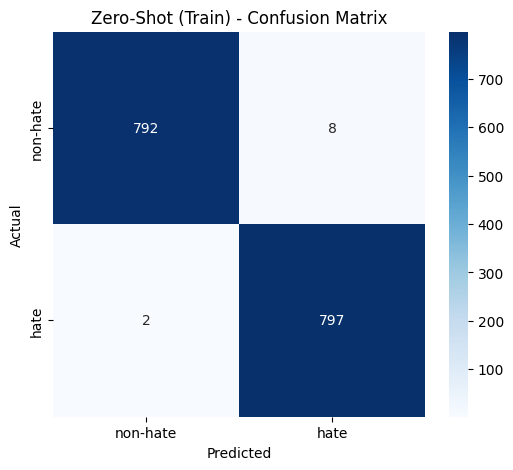

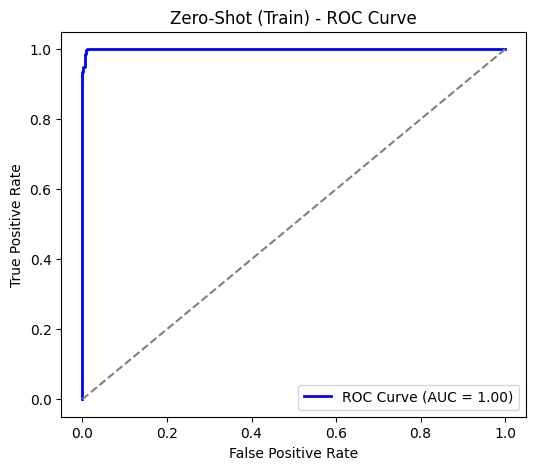

Zero-Shot (Train) Accuracy: 0.9937

Few-Shot (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       1.00      0.80      0.89       800
        hate       0.84      1.00      0.91       799

    accuracy                           0.90      1599
   macro avg       0.92      0.90      0.90      1599
weighted avg       0.92      0.90      0.90      1599



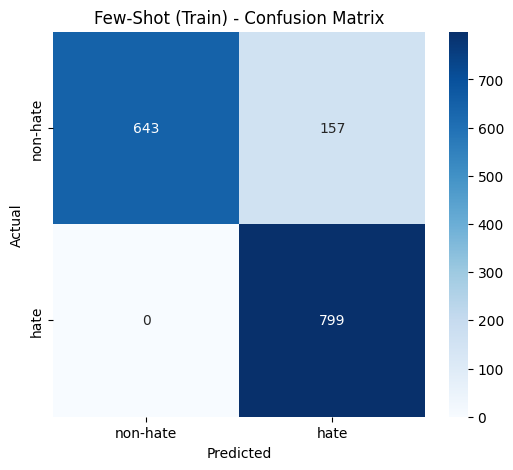

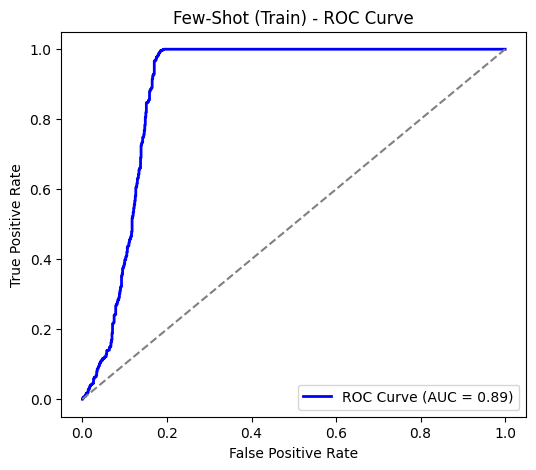

Few-Shot (Train) Accuracy: 0.9018

Chain-of-Thought (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       1.00      0.99      0.99       800
        hate       0.99      1.00      0.99       799

    accuracy                           0.99      1599
   macro avg       0.99      0.99      0.99      1599
weighted avg       0.99      0.99      0.99      1599



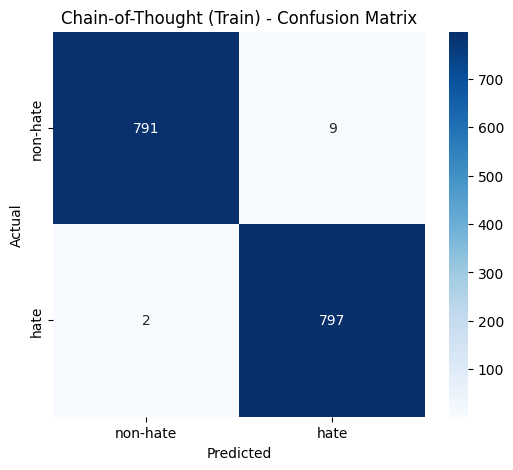

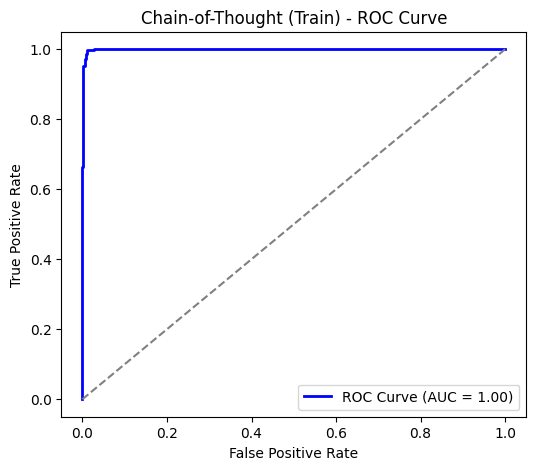

Chain-of-Thought (Train) Accuracy: 0.9931

Combined Prompting (Train) Evaluation:
              precision    recall  f1-score   support

    non-hate       1.00      0.81      0.89       800
        hate       0.84      1.00      0.91       799

    accuracy                           0.90      1599
   macro avg       0.92      0.90      0.90      1599
weighted avg       0.92      0.90      0.90      1599



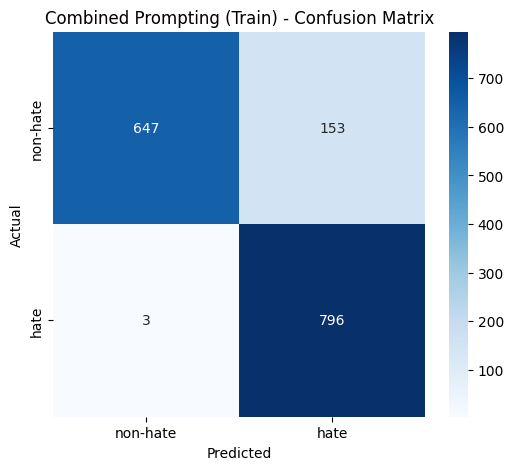

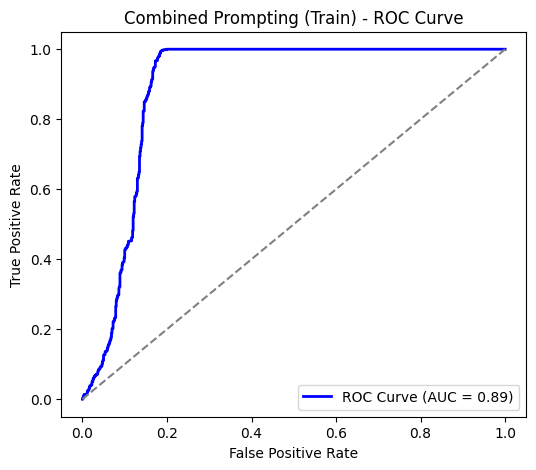

Combined Prompting (Train) Accuracy: 0.9024

---- EVALUATION ON TEST DATA ----

Zero-Shot (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.89      0.98      0.93        50
        hate       0.98      0.88      0.93        50

    accuracy                           0.93       100
   macro avg       0.93      0.93      0.93       100
weighted avg       0.93      0.93      0.93       100



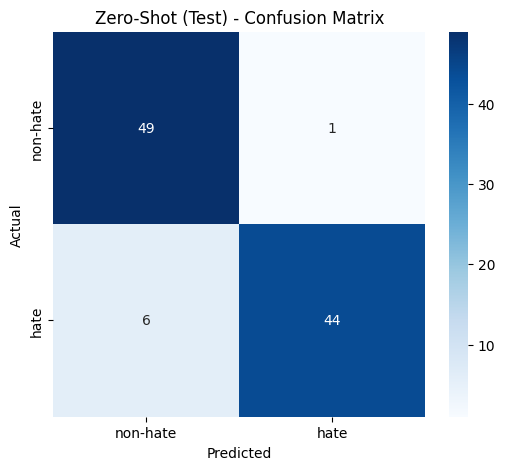

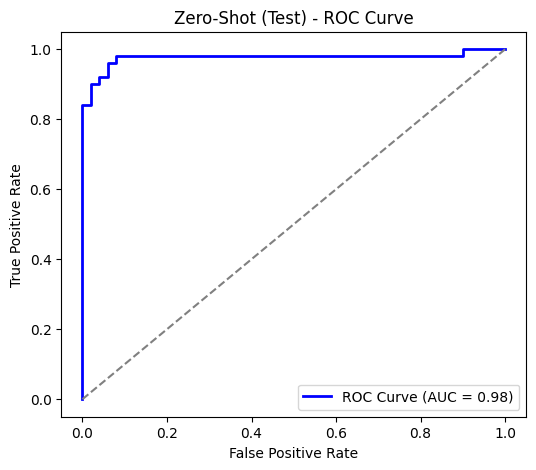

Zero-Shot (Test) Accuracy: 0.9300

Few-Shot (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.89      0.34      0.49        50
        hate       0.59      0.96      0.73        50

    accuracy                           0.65       100
   macro avg       0.74      0.65      0.61       100
weighted avg       0.74      0.65      0.61       100



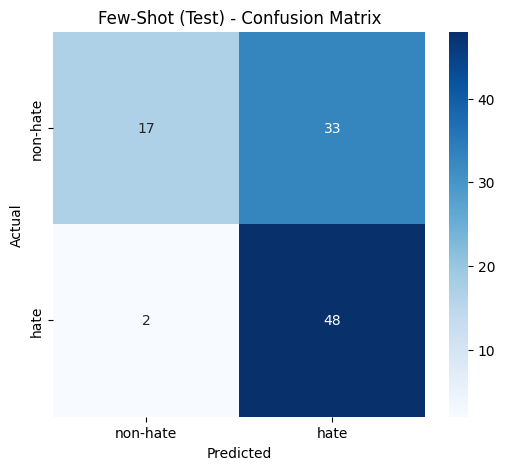

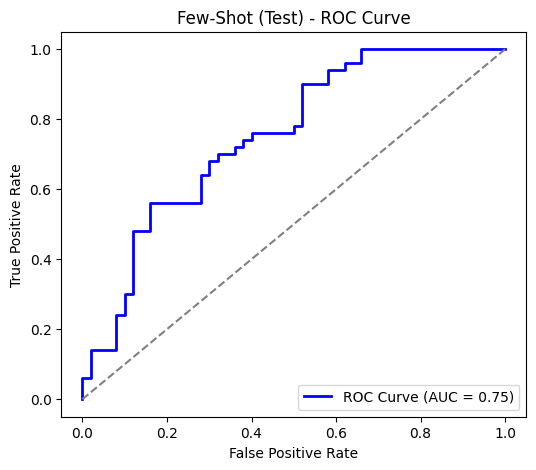

Few-Shot (Test) Accuracy: 0.6500

Chain-of-Thought (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.80      0.98      0.88        50
        hate       0.97      0.76      0.85        50

    accuracy                           0.87       100
   macro avg       0.89      0.87      0.87       100
weighted avg       0.89      0.87      0.87       100



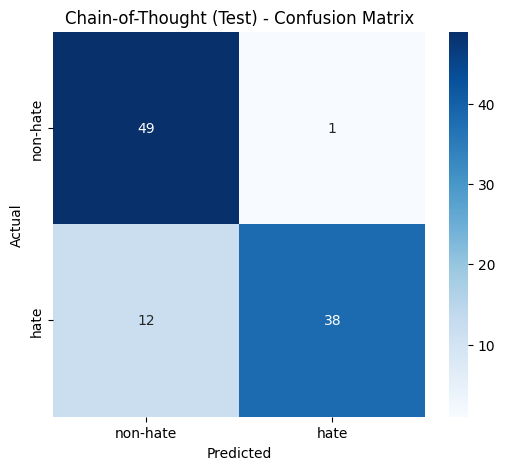

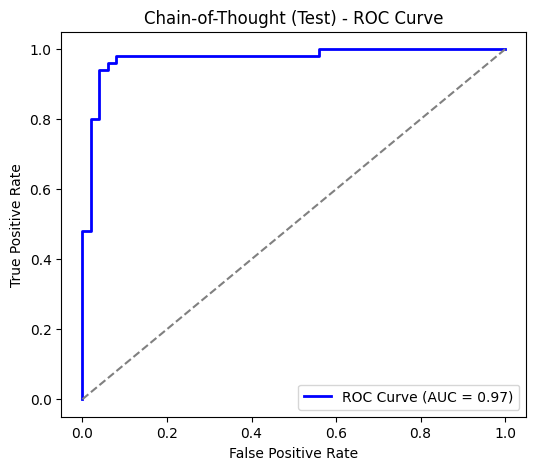

Chain-of-Thought (Test) Accuracy: 0.8700

Combined Prompting (Test) Evaluation:
              precision    recall  f1-score   support

    non-hate       0.89      0.34      0.49        50
        hate       0.59      0.96      0.73        50

    accuracy                           0.65       100
   macro avg       0.74      0.65      0.61       100
weighted avg       0.74      0.65      0.61       100



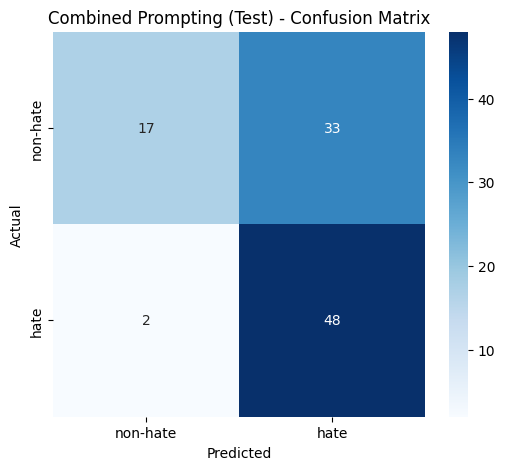

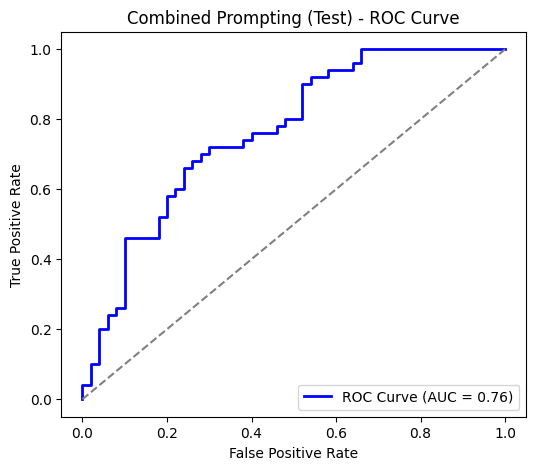

Combined Prompting (Test) Accuracy: 0.6500

🧠 LIME Explanation for Test Sample 5:
Text: ye movie bilkul bakwas thi, time waste mat karo.



In [ ]:
import os     #padhna hai
import torch
import pandas as pd
import numpy as np
import re
import faiss
import matplotlib.pyplot as plt
import seaborn as sns
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, auc
from sentence_transformers import SentenceTransformer
from lime.lime_text import LimeTextExplainer

# ------------------------------
# Load and Preprocess Dataset
# ------------------------------
def load_and_preprocess(file_path):
    df = pd.read_csv(file_path, encoding="latin1")
    
    def clean_text(text):
        text = str(text).lower()
        text = re.sub(r'\s+', ' ', text)
        return text.strip()
    
    df["Text"] = df["Text"].apply(clean_text)
    label_map = {"hate": 1, "non-hate": 0}
    df["Label"] = df["Label"].map(label_map)
    df = df.dropna(subset=["Label"])
    
    return df

train_file_path = "dataset.csv"
test_file_path = "TEST.csv"

df_train = load_and_preprocess(train_file_path)
df_test = load_and_preprocess(test_file_path)

# ------------------------------
# Load Model & Tokenizer
# ------------------------------
saved_model_dir = "./results"
if os.path.exists(saved_model_dir) and os.path.isfile(os.path.join(saved_model_dir, "tokenizer_config.json")):
    print("Loading tokenizer and model from saved directory:", saved_model_dir)
    tokenizer = AutoTokenizer.from_pretrained(saved_model_dir)
    model = AutoModelForSequenceClassification.from_pretrained(saved_model_dir, num_labels=2)
else:
    print("Saved model/tokenizer not found. Loading from original checkpoint.")
    tokenizer = AutoTokenizer.from_pretrained("xlm-roberta-large")
    model = AutoModelForSequenceClassification.from_pretrained("xlm-roberta-large", num_labels=2)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

model.to(device)
model.config.problem_type = "single_label_classification"
model.eval()

# ------------------------------
# FAISS-based RAG Setup
# ------------------------------
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
texts = df_train["Text"].tolist()
labels = df_train["Label"].tolist()

embeddings = embedding_model.encode(texts, convert_to_numpy=True)
dimension = embeddings.shape[1]
faiss_index = faiss.IndexFlatL2(dimension)
faiss_index.add(embeddings)

def retrieve_similar_examples(query_text, top_k=3):
    query_embedding = embedding_model.encode([query_text], convert_to_numpy=True)
    distances, indices = faiss_index.search(query_embedding, top_k)
    examples = [(texts[i], labels[i]) for i in indices[0]]
    return examples

# ------------------------------
# Prompting Techniques
# ------------------------------
def zero_shot_prompt(text):
    return f"Classify the following text as 'hate' or 'non-hate': {text}"

def few_shot_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Here are some examples:\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += f"Now classify the following text:\n{text}\nLabel:"
    return prompt

def chain_of_thought_prompt(text):
    return f"Let's think step by step. Analyze the following text and decide if it is 'hate' or 'non-hate'.\nText: {text}\nReasoning:"

# ✅ Combined Prompt
def combined_prompt(text):
    examples = retrieve_similar_examples(text, top_k=3)
    prompt = "Learn from these examples:\n\n"
    for ex_text, ex_label in examples:
        label_str = "hate" if ex_label == 1 else "non-hate"
        prompt += f"Text: {ex_text}\nLabel: {label_str}\n\n"
    prompt += "Now, let's analyze this text step-by-step:\n"
    prompt += f"Text: {text}\nReasoning:"
    return prompt

# ------------------------------
# Run Inference
# ------------------------------
def run_inference(df, prompt_func):
    all_preds = []
    all_labels = []
    all_probs = []
    for _, row in df.iterrows():
        text, true_label = row["Text"], int(row["Label"])
        prompt_text = prompt_func(text)
        
        inputs = tokenizer(prompt_text, truncation=True, padding="max_length", max_length=128, return_tensors="pt")
        inputs = {k: v.to(device) for k, v in inputs.items()}
        
        with torch.no_grad():
            outputs = model(**inputs)
        logits = outputs.logits.cpu().numpy()
        probs = torch.nn.functional.softmax(torch.tensor(logits), dim=-1).numpy()
        
        pred = np.argmax(logits, axis=-1)[0]
        
        all_preds.append(pred)
        all_labels.append(true_label)
        all_probs.append(probs[0][1])
    
    return all_preds, all_labels, all_probs

# ------------------------------
# Evaluation
# ------------------------------
def evaluate_model(name, y_true, y_pred, y_probs):
    print(f"\n{name} Evaluation:")
    print(classification_report(y_true, y_pred, target_names=["non-hate", "hate"]))

    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["non-hate", "hate"], yticklabels=["non-hate", "hate"])
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title(f"{name} - Confusion Matrix")
    plt.show()

    fpr, tpr, _ = roc_curve(y_true, y_probs)
    roc_auc = auc(fpr, tpr)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, color="blue", lw=2, label=f"ROC Curve (AUC = {roc_auc:.2f})")
    plt.plot([0, 1], [0, 1], color="gray", linestyle="--")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc="lower right")
    plt.show()

    accuracy = accuracy_score(y_true, y_pred)
    print(f"{name} Accuracy: {accuracy:.4f}")

# ------------------------------
# Run All Evaluations
# ------------------------------

# Train
zero_preds_train, zero_labels_train, zero_probs_train = run_inference(df_train, zero_shot_prompt)
few_preds_train, few_labels_train, few_probs_train = run_inference(df_train, few_shot_prompt)
cot_preds_train, cot_labels_train, cot_probs_train = run_inference(df_train, chain_of_thought_prompt)
combined_preds_train, combined_labels_train, combined_probs_train = run_inference(df_train, combined_prompt)

# Test
zero_preds_test, zero_labels_test, zero_probs_test = run_inference(df_test, zero_shot_prompt)
few_preds_test, few_labels_test, few_probs_test = run_inference(df_test, few_shot_prompt)
cot_preds_test, cot_labels_test, cot_probs_test = run_inference(df_test, chain_of_thought_prompt)
combined_preds_test, combined_labels_test, combined_probs_test = run_inference(df_test, combined_prompt)

# Evaluate All
print("\n---- EVALUATION ON TRAIN DATA ----")
evaluate_model("Zero-Shot (Train)", zero_labels_train, zero_preds_train, zero_probs_train)
evaluate_model("Few-Shot (Train)", few_labels_train, few_preds_train, few_probs_train)
evaluate_model("Chain-of-Thought (Train)", cot_labels_train, cot_preds_train, cot_probs_train)
evaluate_model("Combined Prompting (Train)", combined_labels_train, combined_preds_train, combined_probs_train)

print("\n---- EVALUATION ON TEST DATA ----")
evaluate_model("Zero-Shot (Test)", zero_labels_test, zero_preds_test, zero_probs_test)
evaluate_model("Few-Shot (Test)", few_labels_test, few_preds_test, few_probs_test)
evaluate_model("Chain-of-Thought (Test)", cot_labels_test, cot_preds_test, cot_probs_test)
evaluate_model("Combined Prompting (Test)", combined_labels_test, combined_preds_test, combined_probs_test)

# ------------------------------
# LIME and SHAP Explanations
# ------------------------------
class_names = ["non-hate", "hate"]

def predict_proba_lime(texts):
    inputs = tokenizer(texts, truncation=True, padding=True, return_tensors="pt", max_length=128)
    inputs = {k: v.to(device) for k, v in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        logits = outputs.logits
        probs = torch.nn.functional.softmax(logits, dim=1)
    return probs.cpu().numpy()

def explain_with_lime(index=0):
    explainer = LimeTextExplainer(class_names=class_names)
    test_text = df_test.iloc[index]["Text"]
    print(f"\n🧠 LIME Explanation for Test Sample {index}:")
    print(f"Text: {test_text}\n")
    exp = explainer.explain_instance(test_text, predict_proba_lime, num_features=10)
    exp.show_in_notebook(text=True)

# Run Explanations
explain_with_lime(index=5)
